# Lab 2: Create Marketing Campaign Content with Generative AI <a class="anchor" id="top"></a>

In the previous notebook we prepared 3 different datasets that represent our fictional online travel company (user interactions representing flight/trip reviews, item metadata for the flights/trips, and user metadata of our subscribers), created dataset resources in Amazon Personalize, trained an ML model in Amazon Personalize with the item affinity user segmention recipe, and created a batch segment job to generate a user segment of users with an affinity for our target flight/trip.

In this notebook we show how to generate the content for a promotional personalized marketing campaign. [LangChain](https://www.langchain.com/) is a framework for developing applications powered by large language models. The key aspects of this framework allow us to augment the Large Language Models by chaining together various components to create advanced use cases. We will use the [Amazon Bedrock](https://aws.amazon.com/bedrock/) [component](https://python.langchain.com/docs/integrations/llms/bedrock) provided in LangChain. The prompt used in this example creates a custom LangChain prompt template for adding context to the text generation request. The following diagram highlights the focus of this lab.

![Lab 2 Diagram](images/architecture-lab2.png)

Then in the next notebook we will perform content moderation against the generated email text and image to ensure that it meets our Travel company's policies.

## In this notebook

1. [Introduction](#intro)
1. [Generative AI use case 1: email text generation](#usecase1)
1. [Generative AI use case 2: email banner image generation](#usecase2)
1. [Putting it all together](#alltogether)
1. [Storing Useful Variables](#vars)

To run this notebook, you need to have run [the previous notebook: `01_Personalize_User_Segmentation.ipynb`](01_Personalize_User_Segmentation.ipynb), where you trained a ML model with the item affinity user segmentation recipe using Amazon Personalize, selected a flight to promote in our marketing campaign, and used the user segmentation model to generate a segment of users to target with the marketing campaign. At the end of that notebook, you saved some of the variable values, which you now need to load into this notebook.

### Pre-requisites

<div class="alert alert-block alert-warning">
<b>Important:</b> this notebook and the following notebook will be using three <a href="https://aws.amazon.com/bedrock/">Amazon Bedrock</a> foundation models (FMs). Before these foundation models can be invoked, you must have requested and received access to the three FMs in this AWS account. If you haven't already done so, please request access to the following FMs in the Amazon Bedrock console.
<ul>
<li>Anthropic Claude Instant</li>
<li>Stability AI SDXL 1.0</li>
<li>Amazon Titan Embeddings G1 - Text</li>
</ul>
</div>

Before we get started with the implementation we have to make sure that the required latest boto3 and botocore packages are installed. These will be used to leverage the Amazon Bedrock API client.

Additionally we would need langchain one of  the latest versions, which has Amazon Bedrock class implemented under llms module. Also we are installing the transformers framework from HuggingFace, which we will use to quickly count the number of tokens in the input prompt.

<div class="alert alert-block alert-info">
<b>Note:</b> You may receive some warnings/errors about depedencies when you execute the following cell. You can ignore those errors since they are not needed for this lab.
</div>

In [1]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install --upgrade --no-deps --force-reinstall boto3
!{sys.executable} -m pip install --upgrade --no-deps --force-reinstall botocore
!{sys.executable} -m pip install lxml
!{sys.executable} -m pip install anthropic
!{sys.executable} -m pip install --quiet "pillow>=9.5,<10"
!{sys.executable} -m pip install --upgrade langchain-aws

  Using cached boto3-1.34.149-py3-none-any.whl.metadata (6.6 kB)
Using cached boto3-1.34.149-py3-none-any.whl (139 kB)
  Attempting uninstall: boto3
    Found existing installation: boto3 1.34.149
    Uninstalling boto3-1.34.149:
      Successfully uninstalled boto3-1.34.149
  Using cached botocore-1.34.149-py3-none-any.whl.metadata (5.7 kB)
Using cached botocore-1.34.149-py3-none-any.whl (12.4 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.149
    Uninstalling botocore-1.34.149:
      Successfully uninstalled botocore-1.34.149


### Import dependencies

In [2]:
import os
import base64
import io
import time
import json
import random
import boto3
import botocore
import ipywidgets as widgets
from IPython.display import display
from langchain import PromptTemplate

Display some details on some of the dependencies.

In [3]:
# Get the Boto3 version
boto3_version = boto3.__version__

# Get the Botocore version
botocore_version = botocore.__version__

# Print the Boto3 version
print("Current Boto3 Version:", boto3_version)

# Print the Botocore version
print("Current Botocore Version:", botocore_version)

Current Boto3 Version: 1.34.149
Current Botocore Version: 1.34.149


Load variables from the previous notebook.

In [4]:
%store -r

Unable to restore variable 'articles_mlfeatures', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>


## Prepare Amazon Bedrock client

Let's prepare an SDK client to access Amazon Bedrock and provide the LangChain in subsequent cells.

In [5]:
bedrock = boto3.client(service_name='bedrock')

### List all supported foundation models (FMs) in Bedrock

Amazon Bedrock provides API access to several foundation models that support multiple modalities for generative AI use cases. Let's list the FMs using the Bedrock API.

### Selecting FMs for our use case

The modalities for our use case are text-to-text and text-to-image. That is, we're going to provide a text-based prompt as input and receive text as output from a model for the promotional text and provide text or an image as input and receive an image as output from another model for banner image for our email. Take a look at the foundation models listed in the output above and inspect the `inputModalities` and `outputModalities` values to get a sense for the modalities supported by various models.

For our text-to-text use case we're going to use the "Claude Instant" model from Anthropic to generate the text for our promotional email. Its modelId is `anthropic.claude-instant-v1`. This model will provide the quality of output that we're looking for and is ligther, faster, and less expensive than other Anthropic models. Depending on your use case, you may have multiple FMs to choose from. Selecting the right model will involve evaluating the output from different models and considering their price and responsiveness. For more details, please see the [documentation](https://aws.amazon.com/bedrock/claude/).

Since we also want to include a banner image in our promotional email, we will use the "Stable Diffusion XL" model from Stability AI. It's modelId is `stability.stable-diffusion-xl-v0`. This model supports text or an image as input and generates an image as output. For more details, please see the [documentation](https://aws.amazon.com/bedrock/stable-diffusion/).

# Generative AI use case 1: email text content generation <a class="anchor" id="usecase1"></a>
[Back to top](#top)

We'll start by using LangChain and Amazon Bedrock to create the textual content for our email marketing campaign. That is, the email subject and body.

## Preparing LangChain

For our text-to-text use case, we will be using the LangChain framework to help us compose our prompt and invoke our selected Bedrock FM. You can also use the AWS Bedrock SDK to invoke models directly.

Each model accepts arguments that are specific to the model. For the Claude Instant model, we are specifying the following arguments.

- `max_tokens_to_sample`: The maximum number of tokens to generate before stopping. Note that the model may stop before reaching this maximum. This parameter only specifies the absolute maximum number of tokens to generate.
- `temperature`: Amount of randomness injected into the response. Defaults to 1. Ranges from 0 to 1. Use temp closer to 0 for analytical / multiple choice, and closer to 1 for creative and generative tasks.
- `top_k`: Only sample from the top K options for each subsequent token. Used to remove "long tail" low probability responses. More details [here](https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277).

You can learn more about these and other model arguments in Anthropic's [documentation](https://docs.anthropic.com/claude/reference/complete_post).

In [6]:
from langchain_community.chat_models import BedrockChat as Bedrock

bedrock_runtime = boto3.client("bedrock-runtime")

from langchain_aws.chat_models import ChatBedrock

chat_model = ChatBedrock(
    client=bedrock_runtime,
    model_id="anthropic.claude-3-haiku-20240307-v1:0",
)

## Prepare contextual item medata and question template 

In the prior notebook we selected a flight to promote as part of our marketing campaign. We will use attributes of this flight in our prompt to the FM so that it can be used as context to direct the model to generate relevant text.

As a reminder of the item we selected, let's display it again below.

In [7]:
promoted_item

,ITEM_ID,DST_CITY,SRC_CITY,AIRLINE,DURATION_DAYS,MONTH,NUMBER_OF_SEARCH_BY_USER,PROMOTION,DYNAMIC_PRICE,DISCOUNT_FOR_MEMBER,EXPIRED
194,7edbc0ca-d5bf-4895-9980-e69d58fa57d9,Hong Kong,Kuala Lumpur,TigerPounce Express,10,October,7634,Yes,9171,0.5,No


Next let's load a template for our prompt and inspect it.

In [8]:
with open("ticketing_template.txt", "r") as file:
    prompt_template = file.read()

print(prompt_template)

Human: I want you to write a promotional email for an airline flight to a travel destination. The details of the trip are included in <trip></trip> XML tags.

<trip>
<trip_id>{ITEM_ID}</trip_id>
<airline>{AIRLINE}</airline>
<origin_city>{SRC_CITY}</origin_city>
<destination_city>{DST_CITY}</destination_city>
<trip_month>{MONTH}</trip_month>
<trip_year>2023</trip_year>
<original_price>{DYNAMIC_PRICE}</original_price>
<discount_percent>{DISCOUNT_FOR_MEMBER}</discount_percent>
<duration_days>{DURATION_DAYS}</duration_days>
<booking_website>https://demobooking.demo.co</booking_website>
</trip>

Write an email title and body that entices the reader to want to book the trip. Be sure to include a promotion code that is the last 5 digits of the <trip_id>, the <booking_website> where they can book their trip online, and a detailed itinerary of activities they can do at <destination_city> for <duration_days>. Please put the email title in an <email_title> XML tag and the email body in an <email_

Some things to notice in our prompt template:

- The value for our question starts with `Human: ` and ends with `Assitant:`. These are specific tokens used by the Claude model to know where our instruction ends and where the model should generate its output. Each FM typically has its own requirements and idiosyncrasies for template formatting.
- XML tags are used to demarcate structured contextual data. Anthropic's models are trained specifically to work well with XML tags in prompts.
- There are several placeholders in the template such as `{AIRLINE}`, `{SRC_CITY}`, `{DST_CITY}`, and so on. We will use LangChain to substitute the placeholders with values from our promoted item. 

Since there are more fields in our promoted item than we need in the prompt, let's drop the columns that we don't need. If we don't do this, our the placeholder substitution will fail.

In [9]:
promoted_item_for_prompt = promoted_item.drop(columns=["PROMOTION", "EXPIRED", "NUMBER_OF_SEARCH_BY_USER"])
promoted_item_for_prompt

,ITEM_ID,DST_CITY,SRC_CITY,AIRLINE,DURATION_DAYS,MONTH,DYNAMIC_PRICE,DISCOUNT_FOR_MEMBER
194,7edbc0ca-d5bf-4895-9980-e69d58fa57d9,Hong Kong,Kuala Lumpur,TigerPounce Express,10,October,9171,0.5


Next we'll create a helper function to substitute the placeholders with values from our promoted item. We'll use [PromptTemplate](https://python.langchain.com/docs/modules/model_io/prompts/prompt_templates/) from LangChain to help us with this.  

In [10]:
def interpolate_prompt_template(template: str, context: dict) -> str:
    keys = list(context.keys())

    multi_var_prompt = PromptTemplate(
        input_variables=keys,
        template=template
    )

    prompt = multi_var_prompt.format(**context)

    return prompt

### Create prompt for LLM

We'll convert our promoted item from a dataframe to a JSON object so we can use it in our interpolation function. Then we'll call our function to generate our prompt.

In [11]:
promoted_item_json = json.loads(promoted_item_for_prompt.to_json(orient='records', lines=True).splitlines()[0])
prompt = interpolate_prompt_template(prompt_template, promoted_item_json)

print(prompt)

Human: I want you to write a promotional email for an airline flight to a travel destination. The details of the trip are included in <trip></trip> XML tags.

<trip>
<trip_id>7edbc0ca-d5bf-4895-9980-e69d58fa57d9</trip_id>
<airline>TigerPounce Express</airline>
<origin_city>Kuala Lumpur</origin_city>
<destination_city>Hong Kong</destination_city>
<trip_month>October</trip_month>
<trip_year>2023</trip_year>
<original_price>9171</original_price>
<discount_percent>0.5</discount_percent>
<duration_days>10</duration_days>
<booking_website>https://demobooking.demo.co</booking_website>
</trip>

Write an email title and body that entices the reader to want to book the trip. Be sure to include a promotion code that is the last 5 digits of the <trip_id>, the <booking_website> where they can book their trip online, and a detailed itinerary of activities they can do at <destination_city> for <duration_days>. Please put the email title in an <email_title> XML tag and the email body in an <email_body

### Calculate the number of input tokens

Since the cost of invoking FMs is based on the number of input and output tokens, let's see how many tokens are in our prompt. See the Amazon Bedrock [pricing page](https://aws.amazon.com/bedrock/pricing/) for more details on cost.

In [13]:
num_tokens = chat_model.get_num_tokens(prompt)
print(f"Our prompt has {num_tokens} tokens")

Our prompt has 316 tokens


### Request Access to Claude 3 Hiaku

You can confirm it’s enabled on the Model access page of the Amazon Bedrock console. If Claude 3 Hiaku is enabled, the access status will show as Access granted, as shown in the following screenshot. You can enable access to the model by choosing Manage model access, selecting Claude 3 Hiaku Amazon Titan Multimodal Embeddings G1, and then choosing Save Changes.

![Claude Hiaku](images/ClaudeHiaku.png)

## Invoke LLM to generate email title and body

It's time to see what our prompt can do with Claude. The following cell uses LangChain to execute the Claude model in Amazon Bedrock with our prompt. The `%%time` directive will time how long the cell takes to complete.

In [14]:
%%time

email = chat_model.invoke(prompt)
print(email.pretty_repr())

================================== Ai Message ==================================

<email_title>Explore the Vibrant City of Hong Kong with TigerPounce Express!</email_title>

<email_body>
Dear Adventurer,

Are you ready to embark on an unforgettable journey to the vibrant city of Hong Kong? We're excited to offer you a remarkable deal on a 10-day trip with TigerPounce Express, departing from Kuala Lumpur in October 2023.

For a limited time, you can experience the magic of Hong Kong at a discounted rate of 50% off the original price of RM9,171. That means you can book this incredible trip for only RM4,585.50 using the promo code "57d9".

Imagine strolling through the bustling streets of Hong Kong, taking in the stunning skyline, and indulging in the city's vibrant culinary scene. During your 10-day stay, you can explore the iconic landmarks, such as the Victoria Peak, Repulse Bay, and the vibrant Stanley Market. Immerse yourself in the rich culture and history by visiting the Man Mo Tem

How did the model do with our prompt? Did it account for all the specific directions we provided? Do you spot any [hallucinations](https://en.wikipedia.org/wiki/Hallucination_(artificial_intelligence)) in the email subject or email body? 

Note: You will notice some timing details at the end of the output (CPU times and Wall time). These details are generated by the `%%time` directive in the code cell above and are not part of the model's output.

## Prompt Chaining - enhance the content relevance

Prompt chaining can allow you to accomplish a complex task by passing Claude multiple smaller and simpler prompts instead of a very long and detailed one. It can sometimes work better than putting all of a task's subtasks in a single prompt.

Turning a long and complex prompt into a prompt chain can have a few advantages:

- You can write less complicated instructions.
- You can isolate parts of a problem that Claude is having trouble with to focus your troubleshooting efforts.
- You can check Claude's output in stages, instead of just at the end.

https://docs.anthropic.com/claude/docs/prompt-chaining

In the cell below we're going to chain our original prompt with a prompt that includes the top destinations in Hong Kong to provide context on the destinations to recommend in the itinerary. Although the top destinations list is static in this example, we could have also used Amazon Personalize recipes such as Popularity-Count and Trending-Now to surface top destinations based on popularity or trendiness. We'd just need behavioral data on the destinations that travelers visit in the destination city.

In [15]:
import xml.etree.cElementTree as ET

# Load the JSON file
with open('top50inHK.json', 'r') as file:
    top_50_hk = json.load(file)

# Define a prompt and additional statement
additional_statement = "Human: The most fun and delicious places to recommend in Hong Kong are listed in <destination> XML tags and grouped by <category> XML tags below. Please enrich the itinerary with these details and generate again."

categories = []

# Loop through each category and its items
for category, items in top_50_hk.items():
    cat_xml = ET.Element("category", name=category)
    for item in items:
        ET.SubElement(cat_xml, "destination").text = item

    categories.append(ET.tostring(cat_xml, "UTF-8").decode())

combined_tags = "\n".join(categories)

prompt_chaining = f"{prompt}\n\n{additional_statement}\n\n{combined_tags}\n\nAssistant:"

print(prompt_chaining)

Human: I want you to write a promotional email for an airline flight to a travel destination. The details of the trip are included in <trip></trip> XML tags.

<trip>
<trip_id>7edbc0ca-d5bf-4895-9980-e69d58fa57d9</trip_id>
<airline>TigerPounce Express</airline>
<origin_city>Kuala Lumpur</origin_city>
<destination_city>Hong Kong</destination_city>
<trip_month>October</trip_month>
<trip_year>2023</trip_year>
<original_price>9171</original_price>
<discount_percent>0.5</discount_percent>
<duration_days>10</duration_days>
<booking_website>https://demobooking.demo.co</booking_website>
</trip>

Write an email title and body that entices the reader to want to book the trip. Be sure to include a promotion code that is the last 5 digits of the <trip_id>, the <booking_website> where they can book their trip online, and a detailed itinerary of activities they can do at <destination_city> for <duration_days>. Please put the email title in an <email_title> XML tag and the email body in an <email_body

In [16]:
%%time

email2 = chat_model.invoke([prompt_chaining])

print(email2.pretty_repr())

================================== Ai Message ==================================

<email_title>Discover the Flavors and Sights of Hong Kong - 10 Days of Unforgettable Adventure!</email_title>

<email_body>
Dear Traveler,

Embark on an extraordinary journey to the vibrant city of Hong Kong with TigerPounce Express. This October, we invite you to explore the bustling streets, savor the mouthwatering cuisine, and immerse yourself in the rich cultural tapestry of this dynamic destination.

For only $4,585 (50% off the original price), you can enjoy a 10-day trip that will leave you captivated and inspired. With this incredible deal, you'll have the opportunity to discover the best of Hong Kong, from the towering skyscrapers of the city center to the serene natural landscapes.

Unlock the promo code "OUNDCE" and book your trip at https://demobooking.demo.co to secure your spot on this unforgettable adventure.

During your 10-day stay in Hong Kong, you'll have the chance to indulge in the ci

How did this prompt do at enhancing the itinerary? Are there destinations from the top 50 included in the output?

# Generative AI use case 2: email banner image generation <a class="anchor" id="usecase2"></a>
[Back to top](#top)

To add to the visual appeal of our promotional email, we will generate an image that complements the text. We will use the Stable Diffusion XL model in Bedrock from Stability AI for this task.

## Prepare text-to-image prompt

Just like when we created a prompt to generate the email subject and body, we will use a prompt to create our image too. To create our prompt to generate the banner image, we will select a destination from the "Outdoor and Scenic Spots" category in the top 50 things to do in Hong Kong list that we used above. This destination will serve as the subject of our prompt.

In [17]:
prompt_subject = random.choice(top_50_hk["Outdoor and Scenic Spots"])
print(f"The subject of our prompt will be \"{prompt_subject}\"")

The subject of our prompt will be "Hong Kong Disneyland"


In [18]:
prompt_image = f"Photograph of {prompt_subject} in Hong Kong that is hyperrealistic, highly detailed, sharp focus"
print(f"Image prompt: {prompt_image}")

Image prompt: Photograph of Hong Kong Disneyland in Hong Kong that is hyperrealistic, highly detailed, sharp focus


### Prepare negative prompting

In addition to instructing the Stable Diffusion model what we want in our image, we can also instruct the model what we _don't_ want in our image. That is called negative prompts.

Below are the phrases that we want to build into our negative prompt.

In [19]:
negative_prompt_terms = ['people', 'cartoonish', 'painted',
                         'background distorted', 'distorted perspective',
                         'faded color', 'flawed', 'flipped', 'folded', 'improper proportion',
                         'incomplete', 'incorrect geometry', 'inverted', 'kitsch', 'low quality',
                         'low resolution', 'macabre', 'misaligned parts', 'misshapen', 'missing parts',
                         'mutated', 'off-center', 'out of focus', 'over-saturated', 'overexposed', 'oversized',
                         'poorly rendered', 'surreal', 'tilted', 'underexposed', 'unrealistic', 'upside down']

### Stable Diffusion parameters

In addition to the prompts, the Stable Diffusion model supports several parameters that control how the image is generated. Some of the parameters we will use for our image include:

- `cfg_scale`: Prompt strength– Determines how much the final image portrays the prompt random generations. The range is 0—30, and the default value is 10. The `cfg_scale` essentially governs how much the image looks closer to the prompt or input image. The higher the CFG scale, the more the image will match your prompt. Conversely, a lower CFG scale value produces a better-quality image that may differ from the original prompt or image. In Stable Diffusion, CFG stands for Classifier Free Guidance scale. CFG is the setting that controls how closely Stable Diffusion should follow your text prompt. It is applied in text-to-image (txt2img) and image-to-image (img2img) generations. The higher the CFG value, the more strictly it will follow your prompt, in theory. The default value is 10, which gives a good balance between creative freedom and following your direction. A value of 1 will give Stable Diffusion almost complete freedom, whereas values above 15 are quite restrictive.
- `step`: Generation step determines how many times the image is sampled. More steps can result in a more accurate result. The range is 0—150, and the default value is 5.
- `seed`: The seed determines the initial noise setting. If you use the same seed and the same settings as a previous run, inference creates a similar image. The seed value is a random number.
- `style_preset`: the parameter includes enhance, anime, photographic, digital-art, comic-book, fantasy-art, line-art, analog-film, neon-punk, isometric, low-poly, origami, modeling-compound, cinematic, 3d-model, pixel-art, and tile-texture. This list of style presets is subject to change; refer to the latest release and documentation for updates.

https://platform.stability.ai/docs/api-reference#tag/v1generation/operation/textToImage

## Generate image

The following cell will prepare the parameters to pass to the Stable Diffusion model and invoke the model using the Bedrock API client.

In [20]:
%%time

style_preset = "photographic"  # (e.g. photographic, digital-art, cinematic, ...)

# Generate a random seed value
random_seed = random.randint(1, 9999999)  # Adjust the range as needed

request = json.dumps({
    "text_prompts": (
        [{"text": prompt_image, "weight": 1.0}]
        + [{"text": (",".join(negative_prompt_terms)), "weight": -1.0}]
    ),
    "cfg_scale": 20,
    "height": 640, # integer (DiffuseImageHeight) multiple of 64 >= 128, Default: 512
    "width": 1536, # integer (DiffuseImageWidth) multiple of 64 >= 128, Default: 512
    "seed": random_seed,  # Assign the random seed value here
    "steps": 45,
    "style_preset": style_preset,
})
model_id = "stability.stable-diffusion-xl-v1"

response = bedrock_runtime.invoke_model(body=request, modelId=model_id)
response_body = json.loads(response.get("body").read())

print(f"API result: {response_body['result']}")
base_64_img_str = response_body["artifacts"][0].get("base64")

API result: success
CPU times: user 13.7 ms, sys: 2.96 ms, total: 16.7 ms
Wall time: 7.3 s


### Decode generated image

Since the response from Bedrock encodes the image data as a Base64 string, we must decode the string to binary values and feed the binary format to an image processing library so we can render the image. In this case, we will use the Pillow library available in python.

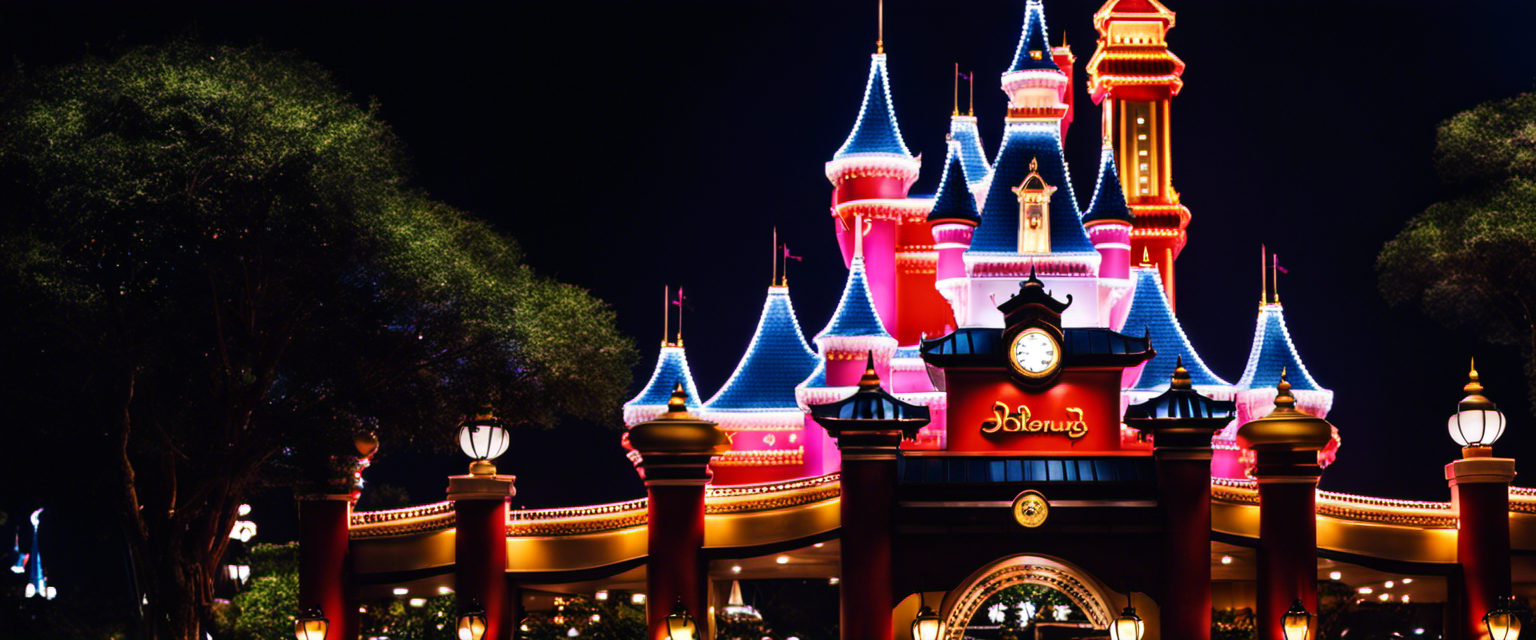

In [21]:
from PIL import Image

image_1 = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
image_1_path = data_dir + "/image_1.png"
image_1.save(image_1_path)
image_1

## Image to Image

Generating images from text is powerful, but in some cases that may require many rounds of prompt refinement to get an image "just right".

Rather than starting from scratch with text each time, image-to-image generation lets us modify an existing image to make the specific changes we'd like.

We'll have to pass our initial image in to the API in base64 encoding, so first let's prepare that. You can use either the initial image from the previous section, or a different one if you'd prefer. The following function will help us do that.

In [22]:
def image_to_base64(img) -> str:
    """Convert a PIL Image or local image file path to a base64 string for Amazon Bedrock"""
    if isinstance(img, str):
        if os.path.isfile(img):
            print(f"Reading image from file: {img}")
            with open(img, "rb") as f:
                return base64.b64encode(f.read()).decode("utf-8")
        else:
            raise FileNotFoundError(f"File {img} does not exist")
    elif isinstance(img, Image.Image):
        print("Converting PIL Image to base64 string")
        buffer = io.BytesIO()
        img.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError(f"Expected str (filename) or PIL Image. Got {type(img)}")

### Use the sample image as input image

We load a sample image to use as the input image.

Converting PIL Image to base64 string


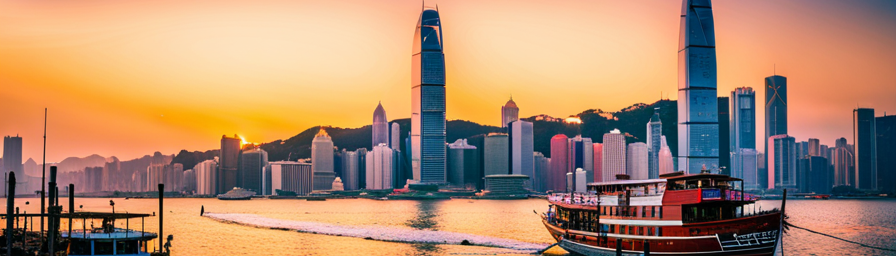

In [23]:
# Define image_to_image1 as a PIL Image object with your actual image file path)
image_to_image1 = Image.open('image_to_image1.png')

init_image_b64 = image_to_base64(image_to_image1)
image_to_image1

### Generate image

Since the sample image is of Victoria Harbour, we'll design a prompt that changes the lighting and attempts to remove boats from the image.

In [24]:
%%time

prompt_image = f"Photograph of Victoria Harbour in Hong Kong, night, night lights, hyperrealistic, highly detailed, sharp focus"

if not "boats" in negative_prompt_terms:
    negative_prompt_terms.insert(0, "boats")

# Generate a random seed value
random_seed = random.randint(1, 9999999)  # Adjust the range as needed

request = json.dumps({
    "text_prompts": (
        [{"text": prompt_image, "weight": 1.0}]
        + [{"text": (",".join(negative_prompt_terms)), "weight": -1.0}]
    ),
    "cfg_scale": 20,
    "init_image": init_image_b64,
    "image_strength": 0.7, # number <float> (InitImageStrength) [ 0 .. 1 ], Default: 0.35, Values close to 1 will yield images very similar to the init_image
    "height": 640, # integer (DiffuseImageHeight) multiple of 64 >= 128, Default: 512
    "width": 1536, # integer (DiffuseImageWidth) multiple of 64 >= 128, Default: 512
    "seed": random_seed,
    "start_schedule": 0.5,
    "steps": 45,
    "style_preset": style_preset,
})
model_id = "stability.stable-diffusion-xl-v1"

response = bedrock_runtime.invoke_model(body=request, modelId=model_id)
response_body = json.loads(response.get("body").read())

image_2_b64_str = response_body["artifacts"][0].get("base64")
print(f"API result: {response_body['result']}")

API result: success
CPU times: user 7.52 ms, sys: 3.88 ms, total: 11.4 ms
Wall time: 3.43 s


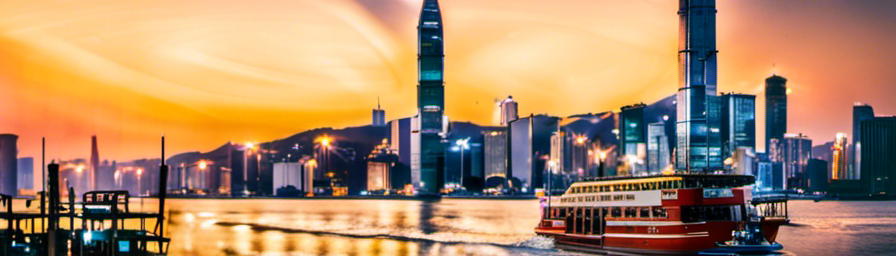

In [25]:
image_2 = Image.open(io.BytesIO(base64.decodebytes(bytes(image_2_b64_str, "utf-8"))))
image_2_path = data_dir + "/image_2.png"
image_2.save(image_2_path)
image_2

# Putting it all together <a class="anchor" id="alltogether"></a>
[Back to top](#top)

With our email subject, email body, and banner image generated, let's assemble the finished product for each of our target users. To keep it simple, we'll create HTML pages that represent an HTML email that we'd send to each user.

First, we need to isolate the email subject and title from the generated response from the Claude Instant model. If you recall from the prompt used to generate the email text, we asked Claude to place the email title/subject and body within XML tags. This instruction in the prompt allows us to more easily parse the response to separate these two pieces of content. To do so, we'll wrap the output in an outer `<email></email>` tag and then parse it as an XML document.

In [26]:
import xml.etree.ElementTree as ET
root = ET.fromstring("<email>" + email2.pretty_repr() + "</email>")
subject = root.find("email_title").text.strip()
body = root.find("email_body").text.strip()

print(f"Email subject: {subject}")
print(f"Email body: {body}")

Email subject: Discover the Flavors and Sights of Hong Kong - 10 Days of Unforgettable Adventure!
Email body: Dear Traveler,

Embark on an extraordinary journey to the vibrant city of Hong Kong with TigerPounce Express. This October, we invite you to explore the bustling streets, savor the mouthwatering cuisine, and immerse yourself in the rich cultural tapestry of this dynamic destination.

For only $4,585 (50% off the original price), you can enjoy a 10-day trip that will leave you captivated and inspired. With this incredible deal, you'll have the opportunity to discover the best of Hong Kong, from the towering skyscrapers of the city center to the serene natural landscapes.

Unlock the promo code "OUNDCE" and book your trip at https://demobooking.demo.co to secure your spot on this unforgettable adventure.

During your 10-day stay in Hong Kong, you'll have the chance to indulge in the city's renowned culinary scene. Savor authentic Cantonese delicacies at renowned restaurants like 

Now we can reference these text elements more easily in our HTML email.

In [27]:
from IPython.display import display, HTML

body_html = body.replace("\n", "<br/>")
display(HTML(f'<hr/><h1>{subject}</h1><img src="{data_dir}/image_2.png"/><p>{body_html}</p><hr/>'))

# Summary <a class="anchor" id="summary"></a>
[Back to top](#top)

In this notebook we used two foundation models available in Amazon Bedrock to generate the subject and body of our promotional email as well as a banner image to include in our email. We also learned how to use the LangChain framework to make working with and building prompts easier. In the third and final notebook, we'll learn how to add content moderation to our project to ensure that the content created in those notebook does not contain any unsafe or inappropriate content.

## Storing Useful Variables <a class="anchor" id="vars"></a>
[Back to top](#top)

Before exiting this notebook, run the following cells to save variables for use in the next notebook.

In [28]:
email_response_text = email2.pretty_repr()

In [29]:
%store email_response_text
%store image_1_path
%store image_2_path

Stored 'email_response_text' (str)
Stored 'image_1_path' (str)
Stored 'image_2_path' (str)


[Go to the next notebook `03_Content_Moderation_Generative_AI.ipynb`](03_Content_Moderation_Generative_AI.ipynb) to continue.